In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import numpy as np

import jax.numpy as jnp

import h5py

import corner

import gw_pop_numpyro

import seaborn as sns

In [2]:
from gw_pop_numpyro import config, setup_injections_PE, numpyro_sample, popmodels, postproc, plot_helper

from delay_time_helper import ptau, draw_delay_times, add_formation_tL

tmaxmax = config.cosmo_dict["lookback_time"](20)

Text(0.5, 1.0, 'example formation rate curves within prior')

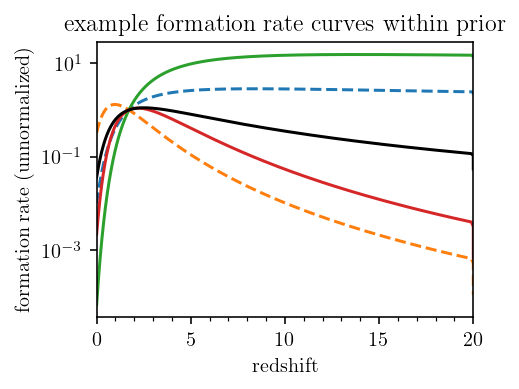

In [3]:
from gw_pop_numpyro import distributions as dist

tL_plot = np.linspace(0, 13.7, 1000)*1e3
z_plot = config.cosmo_dict["z_at_lookback_time"](tL_plot)
y = dist.rate_lookbacktime(tL_plot, 0.3, 5e-4, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 5e-4, config.cosmo_dict)


plt.plot(z_plot, y, ls = '--')
plt.plot(z_plot, y2, ls = '--')

y = dist.rate_lookbacktime(tL_plot, 0.3, 1e-3, config.cosmo_dict)
y2 = dist.rate_lookbacktime(tL_plot, 3, 1e-3, config.cosmo_dict)

plt.plot(z_plot, y)
plt.plot(z_plot, y2)


plt.plot(z_plot, dist.rate_lookbacktime(tL_plot, 1.3, 5e-4, config.cosmo_dict), c = 'k')

plt.yscale('log')
plt.xlim(0,20)

plt.xlabel('redshift')
plt.ylabel('formation rate (unnormalized)')
plt.title('example formation rate curves within prior')

In [4]:
tL_forms = np.linspace(1, config.cosmo_dict["age_of_universe"], 1000)


def formation_rate_at_tL_samps(hypersamps, tL_forms):
    
    zmerge_grid = jnp.linspace(0, config.zmerge_max, 1000)
    
    hyper_keys = pop_model._param_names

    nhyper = len(hypersamps[hyper_keys[0]])
    
    Rfs = np.zeros((nhyper, len(tL_forms)))
    
    for i in range(nhyper):
        
        pop = pop_model(**{key: hypersamps[key][i] for key in hyper_keys})
    
        log_Rf = jnp.log(hypersamps["rate_N"][i]) + pop.log_Vct_dist(tL_forms) - pop.logznorm(zmerge_grid, PEsamples["tau_grid"], PEsamples["ptau_grid"])
                
        Rfs[i, :] = jnp.exp(log_Rf)
    
    return Rfs

### Population model

In [5]:
pop_model = popmodels.bandpass_plpeak_mass_formation_time_Gaussian_chieff_dist

print(pop_model._param_names)

print(pop_model._source_params)

['mmin', 'mmax', 'alpha1', 'fpeak', 'mupeak', 'sigpeak', 'n1', 'n2', 'beta', 'at', 'bt', 'mu', 'sig']
['mass_1_source', 'mass_2_source', 'redshift', 'chi_eff', 'formation_lookback_time']


### define and sample from prior

In [6]:
prior = numpyro_sample.get_prior_function(pop_model, config.DEFAULT_HYPERPRIOR) 

prior_sampler, prior_samples = numpyro_sample.sample_from_posterior(prior, num_warmup = 2000, num_samples = 2000, progress_bar = True)

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:10<00:00, 396.18it/s, 7 steps of size 6.29e-01. acc. prob=0.86]


In [7]:
config.DEFAULT_HYPERPRIOR

{'mmin': [3, 12],
 'mmax': [30, 80],
 'alpha1': [-6, -0.5],
 'fpeak': [0.0001, 0.3],
 'mupeak': [25, 50],
 'sigpeak': [2, 8],
 'n1': [2, 20],
 'n2': [2, 20],
 'beta': [-2, 6],
 'a': [0, 6],
 'b': [0, 6],
 'zp': [0.5, 6],
 'zmax': [10, 20.0],
 'mu': [-0.5, 0.5],
 'sig': [0.03, 0.5],
 'at': [0.3, 2.6],
 'bt': [0.0001, 0.001]}

In [8]:
#add in prior on normalization
prior_samples["rate_N"] = np.exp(7 + 6 * np.random.random(2000))

### PE samples and injections

In [9]:
PE_settings = {
        'dir_O3a' : "/Users/mayafishbach/Desktop/O3samples/O3a/",
        'dir_O3a_p1' : "/Users/mayafishbach/Desktop/O3samples/O3a-p1/",
        'dir_O3b': "/Users/mayafishbach/Desktop/O3samples/O3b/",
        'dir_O2' :  "/Users/mayafishbach/Desktop/O3samples/GWTC-1_sample_release/",
        'exclude' : ['GW170817', 'GW190425', 'GW190814', 'GW190426', 'GW190909', 'GW190514_065416', 'GW190917', 'GW200105', 'GW200115', 'GW200220_061928', "GW191113_071753", "GW191126_115259", "GW191204_110529", "GW191219_163120", "GW200208_222617", "GW200210_092254", "GW200220_061928", "GW200220_124850", "GW200306_093714", "GW200308_173609", "GW200322_091133"],
        'spin' :  'eff',
        'tL' : False,
        'Vc_t' : False,
        'nsamples' : 3000
        }


PEsamples, events = setup_injections_PE.preprocess_PE(**PE_settings)
inj, Ndraw,  Tobs_years = setup_injections_PE.preprocess_injections(**config.default_injection_settings)

In [10]:
len(events)

69

In [11]:
seed = 1148

### Fit for formation rate assuming delay time model

In [12]:
def fit_formation_rate(tmin = 10, alpha = -1, num_warmup = 2000, num_samples = 4000):
    add_formation_tL(samples = PEsamples, tmin = tmin, alpha = alpha, truncate_tmax = False, seed = seed)
    add_formation_tL(samples = inj, tmin = tmin, alpha = alpha, truncate_tmax = False, seed = seed)
    
    #just to ensure that none of the functions break, set all formation times larger than first star formation tmaxmax to tmaxmax.
    #The formation rate is defined to be identically zero at tmaxmax (and higher) anyway,
    #so this is just a convenience.
    #we also have to do it in a roundabout way because jax.numpy doesn't let you change array elements like numpy does.
    inj_inter = np.array(inj["formation_lookback_time"])
    inj_inter[inj_inter >= tmaxmax] = tmaxmax
    inj["formation_lookback_time"] = inj_inter
    plt.hist(inj["formation_lookback_time"]/1e3)
    plt.xlabel("injections: formation lookback time")
    plt.ylabel("counts")
    plt.show()
    
    PE_inter = np.array(PEsamples["formation_lookback_time"])
    PE_inter[PE_inter >= tmaxmax] = tmaxmax
    PEsamples["formation_lookback_time"] = PE_inter
    plt.hist(PEsamples["formation_lookback_time"].flatten()/1e3)
    plt.xlabel("PE samples: formation lookback time")
    plt.ylabel("counts")
    plt.show()
    
    #define posterior
    posterior_func = numpyro_sample.get_posterior_function(pop_model, prior, PEsamples, inj, Ndraw)

    #sample from posterior
    sampler, samples = numpyro_sample.sample_from_posterior(posterior_func, num_warmup = num_warmup, num_samples = num_samples, progress_bar = True)
    
    sampler.print_summary()
    
    #plot posterior on formation rate evolution params
    sns.kdeplot(samples['at'], samples['bt']*1e3, levels = [0.05, 0.1, 0.5])
    plt.scatter(1.34, 0.43, marker = '*')
    plt.xlabel('at')
    plt.ylabel('bt')
    plt.title('formation rate hyperparams')
    plt.show()
    
    #save hyperposterior samples
    #with h5py.File(f"formation_time_hypersamples_tmin{tmin}_al{-alpha}_fix.h5", 'w') as out:
        #for key in samples.keys():
        #    out.create_dataset(name = key, data = samples[key])
        
    #compute rate in post-processing
    hypersamps = dict()
    for key in samples.keys():
        hypersamps[key] = samples[key]
        
    hypersamps = postproc.save_lognorm(hypersamps, pop_model, lognorm_kwargs = dict(tau_grid = PEsamples["tau_grid"], ptau_grid = PEsamples["ptau_grid"]))
    hypersamps = postproc.save_rate_N(hypersamps, inj, Ndraw, Tobs_years, len(events), pop_model)
    
    #plot hyperposterior on rate_N
    plt.hist(np.log(hypersamps["rate_N"]))
    plt.xlabel('log_rate_N')
    plt.ylabel('counts')
    plt.show()

    #compute formation rate on a grid
    Rfs = formation_rate_at_tL_samps(hypersamps, tL_forms)
    
    #compute prior formation rate draws on grid of tL_forms, this depends on assumed delay time distribution for normalization
    Rfs_prior = formation_rate_at_tL_samps(prior_samples, tL_forms)
    
    
    #reweight PE and injections
    obs_samps_allparams, pred_samps_allparams = postproc.reweight_PE_inj(hypersamps, PEsamples, inj, pop_model)
    
    #save hyperposterior, reweighted PE, reweighted injections, and rate (posterior and prior) samples
    with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'w') as out:
        
        hypersamples = out.create_group("hypersamples")
        for key in hypersamps.keys():
            hypersamples.create_dataset(name = key, data = hypersamps[key])
            
        reweighted_PE = out.create_group("reweighted_PE")
        for key in obs_samps_allparams.keys():
            reweighted_PE.create_dataset(name = key, data = obs_samps_allparams[key])
            
        reweighted_inj = out.create_group("reweighted_inj")
        for key in pred_samps_allparams.keys():
            reweighted_inj.create_dataset(name = key, data = pred_samps_allparams[key])
        
        out.create_dataset(name = 'tL_forms', data = tL_forms)
        out.create_dataset(name = 'Rf_posterior', data = Rfs)
        out.create_dataset(name = 'Rf_prior', data = Rfs_prior)
        
    #plot prior and posterior on formation rate
    fig, ax = plt.subplots(constrained_layout=True)

    xs = config.cosmo_dict["z_at_lookback_time"](tL_forms)

    plot_helper.plot_bands(ax, xs, 1e9 * Rfs_prior, color = sns.color_palette()[1])
    
    plot_helper.plot_bands(ax, xs, 1e9 * Rfs)

    ax.set_yscale('log')

    ax.set_xlim(0, 20)

    ax.set_xlabel('Redshift')

    ax.set_ylabel('Formation rate')
    
    plt.show()

### "Default" delay time model 
(power law with minimum 10 Myr and slope -1) 

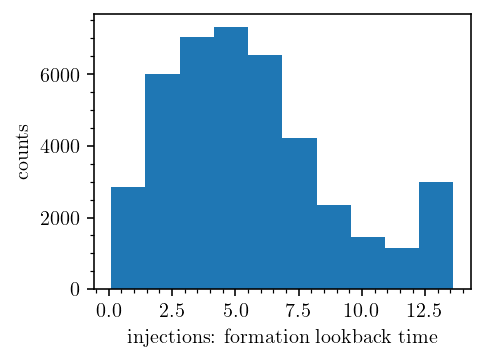

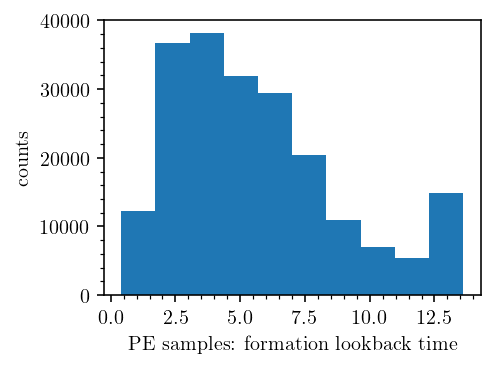

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [27:56<00:00,  3.58it/s, 15 steps of size 1.99e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -3.14      0.45     -3.18     -3.85     -2.37   1148.62      1.00
        at      1.38      0.64      1.34      0.32      2.33   3509.33      1.00
      beta      1.47      1.08      1.35     -0.12      3.25   2438.47      1.00
        bt      0.00      0.00      0.00      0.00      0.00   2917.60      1.00
     fpeak      0.00      0.01      0.00      0.00      0.01   1262.85      1.00
      mmax     63.80     13.73     68.06     40.36     80.00   1152.44      1.00
      mmin      7.96      1.01      8.06      6.34      9.54   2238.47      1.00
        mu      0.06      0.02      0.06      0.03      0.08   3365.57      1.00
    mupeak     34.69      1.59     34.84     32.55     37.33   1095.93      1.00
        n1     14.32      3.90     14.85      8.62     19.98   5274.43      1.00
        n2      8.01      5.34      6.33      2.00     16.81   2044.28      1.00
       sig      0.09      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


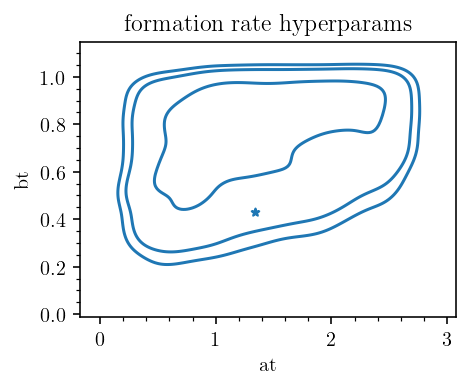

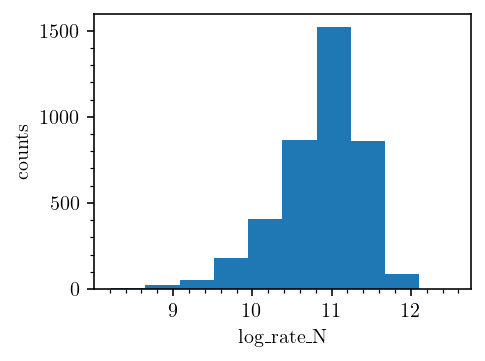

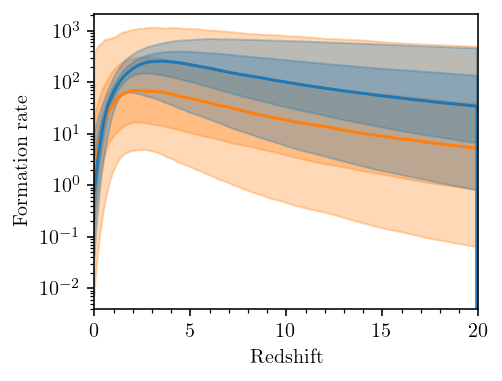

In [13]:
fit_formation_rate(tmin = 10, alpha = -1)

### Shallow delay time model (representative of SMT-only)
(power law with minimum 10 Myr and slope -0.35) 

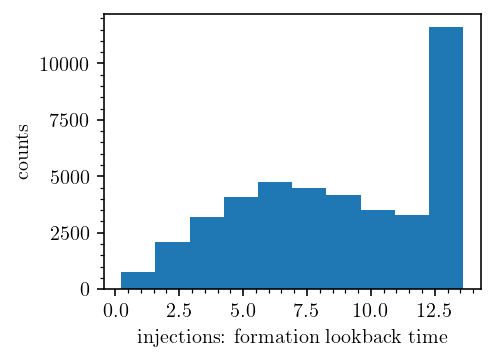

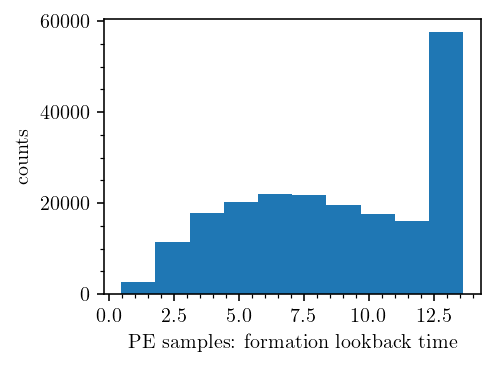

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [28:56<00:00,  3.45it/s, 15 steps of size 1.92e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -2.95      0.43     -2.97     -3.67     -2.24   1029.08      1.00
        at      1.65      0.62      1.72      0.71      2.60   2335.85      1.00
      beta      1.96      1.11      1.82      0.22      3.64   1824.28      1.00
        bt      0.00      0.00      0.00      0.00      0.00   2758.01      1.00
     fpeak      0.01      0.01      0.00      0.00      0.01    964.53      1.00
      mmax     65.58     12.86     69.65     44.09     80.00   1106.52      1.00
      mmin      7.83      1.02      7.95      6.12      9.36   1808.00      1.00
        mu      0.06      0.02      0.06      0.03      0.08   2809.76      1.00
    mupeak     35.10      1.54     35.19     32.85     37.70   2000.65      1.00
        n1     14.29      3.92     14.89      8.71     19.99   6792.70      1.00
        n2      8.47      5.39      7.17      2.00     17.11   2255.56      1.00
       sig      0.09      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


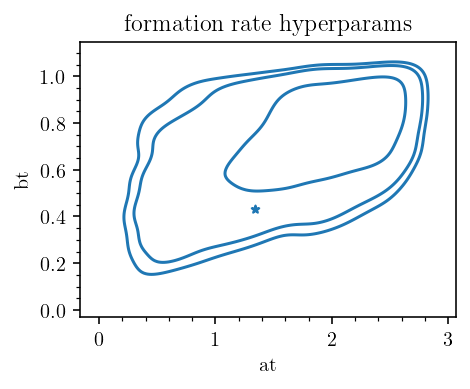

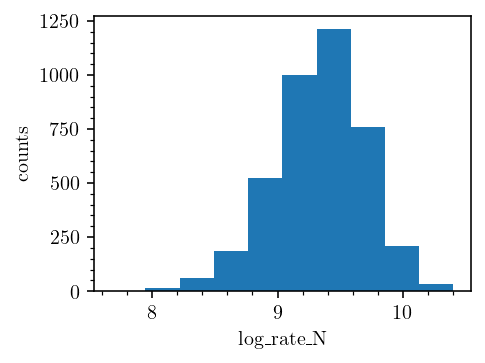

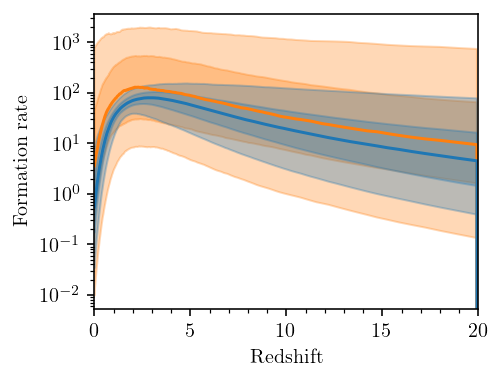

In [14]:
fit_formation_rate(tmin = 10, alpha = -0.35)

### Medium delay time model
(power law with minimum 10 Myr and slope -0.7) 

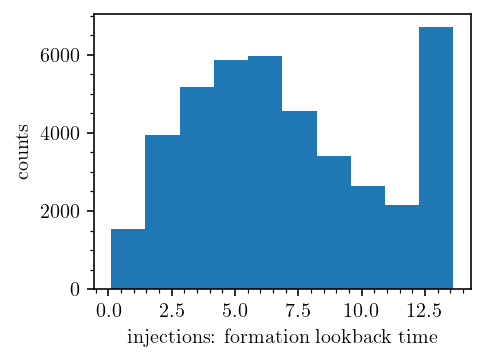

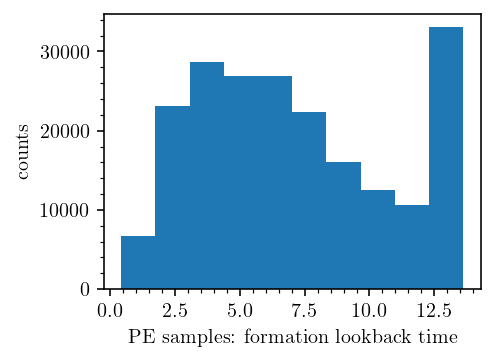

sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 6000/6000 [28:10<00:00,  3.55it/s, 15 steps of size 1.93e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    alpha1     -3.06      0.43     -3.09     -3.80     -2.41   1093.50      1.00
        at      1.20      0.66      1.08      0.30      2.22   3315.97      1.00
      beta      1.97      1.04      1.84      0.28      3.60   2100.23      1.00
        bt      0.00      0.00      0.00      0.00      0.00   3111.85      1.00
     fpeak      0.00      0.01      0.00      0.00      0.01    939.35      1.00
      mmax     65.19     13.08     69.37     42.82     79.99   1075.59      1.00
      mmin      7.79      0.96      7.90      6.17      9.27   2693.24      1.00
        mu      0.05      0.02      0.06      0.02      0.08   3469.72      1.00
    mupeak     34.76      1.40     34.83     32.50     36.96   1751.05      1.00
        n1     14.29      3.94     14.89      8.46     19.97   4584.71      1.00
        n2      8.38      5.38      6.94      2.00     17.19   2387.62      1.00
       sig      0.09      0

/opt/anaconda3/envs/jaxpop/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


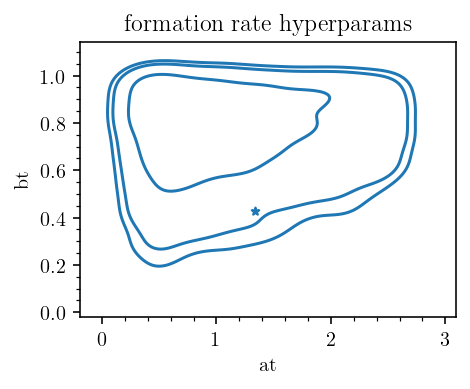

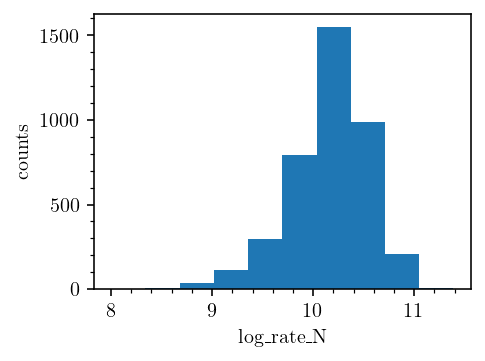

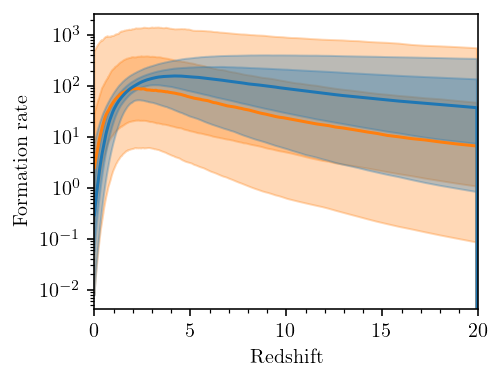

In [15]:
fit_formation_rate(tmin = 10, alpha = -0.7)

### sanity checks

In [16]:
import delay_time_helper
from gw_pop_numpyro import distributions

tmaxmax = config.cosmo_dict["lookback_time"](20)


def plot_merger_rate_from_formation_rate(tmin, alpha):
    
    zs = np.linspace(0,1,10)
    
    age_m_grid = config.cosmo_dict["age_of_universe"] - config.cosmo_dict["lookback_time"](zs)
    
    tau_grid = np.logspace(np.log10(tmin), np.log10(tmaxmax), 1000)
    ptau_grid =  delay_time_helper.ptau(tau_grid, tmin, alpha = alpha, tmax = tmaxmax)
    
    with h5py.File(f"formation_rate_hypersamples_plusgrid_tmin{tmin}_al{-alpha}.h5", 'r') as inp:
        Rfs = np.array(inp["Rf_posterior"])
        Rfs_prior = np.array(inp["Rf_prior"])
        tL_forms = np.array(inp["tL_forms"])
    
    merger_rates_post = np.zeros((1000,10))
    merger_rates_prior = np.zeros((1000, 10))
    
    for i in range(1000):

        def formation_rate_at_age_func_post(T):
            return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs[i,:])
        
        def formation_rate_at_age_func_prior(T):
            return np.interp(config.cosmo_dict["age_of_universe"] - T, tL_forms, Rfs_prior[i,:])

        merger_rates_post[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func_post)

        merger_rates_prior[i,:] = delay_time_helper.merger_rate_at_age_from_formation_delay(age_m_grid, tau_grid, ptau_grid, formation_rate_at_age_func_prior)
    
    fig, ax = plt.subplots(constrained_layout=True)


    plot_helper.plot_bands(ax, zs, 1e9 * merger_rates_post, color = 'red', plot_kwargs = dict(label = 'posterior'))
    
    plot_helper.plot_bands(ax, zs, 1e9 * merger_rates_prior, color = 'green', plot_kwargs = dict(label = 'prior'))
    
    ax.legend(loc = 'best')
    
    ax.set_xlabel('redshift')
    
    ax.set_yscale('log')
    ax.set_ylabel('Merger rate')
    
    ax.grid()
    plt.title(f"alpha = {alpha}")
    plt.show()
    
    plt.hist(merger_rates_post[:,-1]/merger_rates_post[:,0], alpha = 0.3, color = 'red', label = 'posterior', density = True)
    plt.hist(merger_rates_prior[:,-1]/merger_rates_prior[:,0], alpha = 0.3, color = 'green', label = 'prior', density = True)
    
    plt.legend(loc = 'best')
    
    plt.xlabel('merger rate at (z = 1) / merger rate at (z = 0)')
    
    plt.ylabel('probability density')
    
    plt.title(f"alpha = {alpha}")
    plt.show()

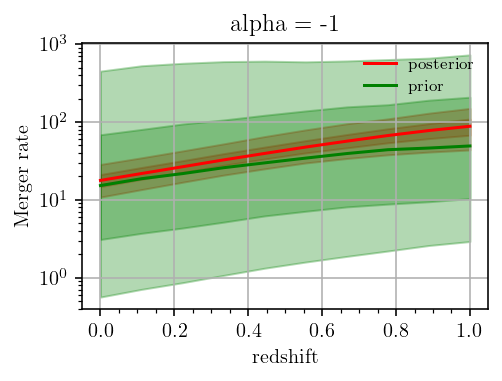

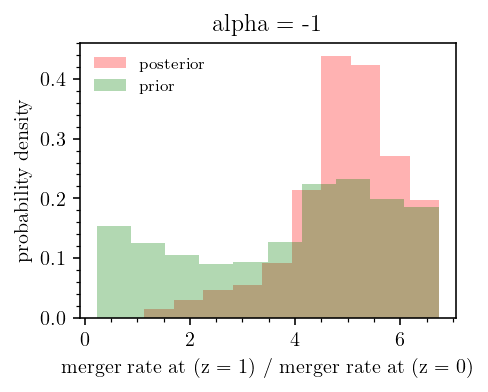

In [17]:
plot_merger_rate_from_formation_rate(10, -1)

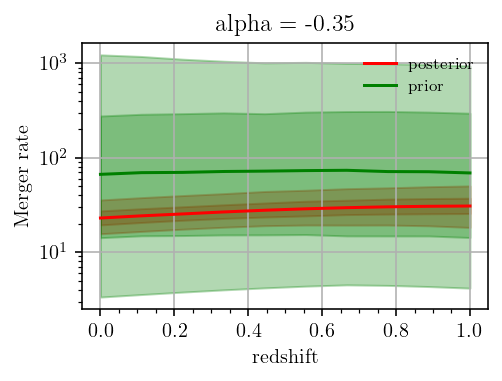

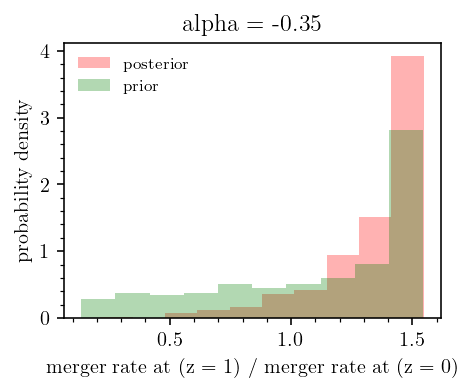

In [18]:
plot_merger_rate_from_formation_rate(10, -0.35)

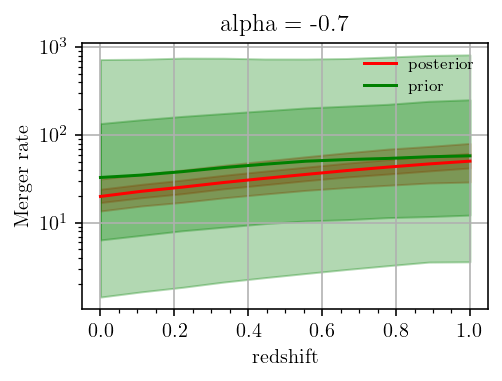

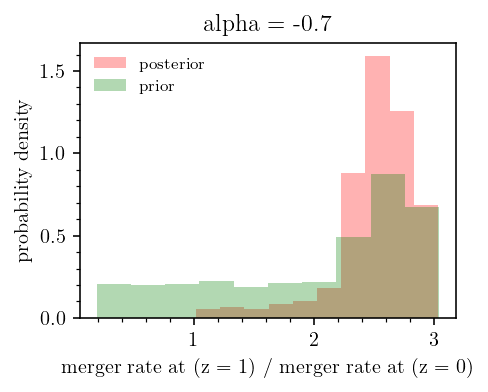

In [19]:
plot_merger_rate_from_formation_rate(10, -0.7)

Inferred merger rate doesn't rise steeply enough, but that's because it gets cut off by the prior. 

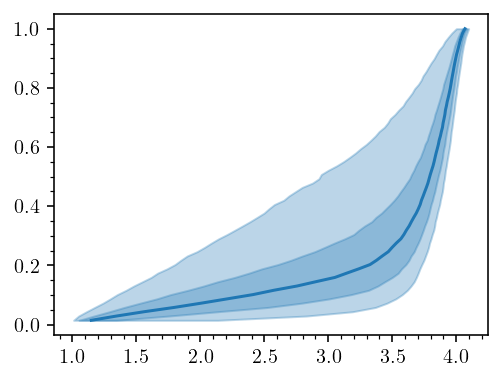

In [30]:
fig, ax = plt.subplots(constrained_layout = True)

lines_tau = plot_helper.plot_cdf_bands(ax, np.log10(reweighted_PE_al01["formation_lookback_time"] - config.cosmo_dict["lookback_time"](reweighted_PE_al01["redshift"])), plot_kwargs = dict(label = r'delay time $\alpha_\tau = -1$'), ret_lines = True)

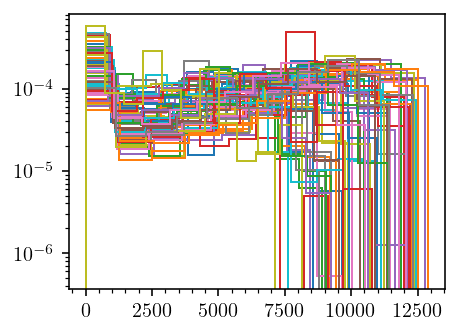

In [41]:
for i in range(69):
    tau = (reweighted_PE_al01["formation_lookback_time"][:,i] - config.cosmo_dict["lookback_time"](reweighted_PE_al01["redshift"][:,i]))
    plt.hist(tau, density = True, histtype = 'step')
plt.yscale('log')